# Building Recommender Model 

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import plotly 
import plotly.express as px
import json

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.neighbors import KernelDensity
from sklearn.metrics import silhouette_score

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel

pd.set_option('display.max_columns', 100)
style.use('seaborn-whitegrid')

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [59]:
res = pd.read_csv('../data/restaurants_final.csv')

## Location-Based Clustering

In [60]:
res_loc = res[['lat', 'lng']].copy()

In [61]:
ss = StandardScaler()
res_loc_ss = ss.fit_transform(res_loc)

In [62]:
scores = []
for k in range(20, 40):
    cl = KMeans(n_clusters=k, random_state=42)
    cl.fit(res_loc_ss)
    inertia = cl.inertia_
    sil = silhouette_score(res_loc_ss, cl.labels_)
    scores.append([k, inertia, sil])
    
score_df = pd.DataFrame(scores)
score_df.columns = ['k', 'inertia', 'silhouette']
score_df.head(5)

,k,inertia,silhouette
0,20,402.539507,0.467786
1,21,380.305107,0.473996
2,22,360.063710,0.474083
3,23,339.462927,0.473275
4,24,319.248022,0.471000


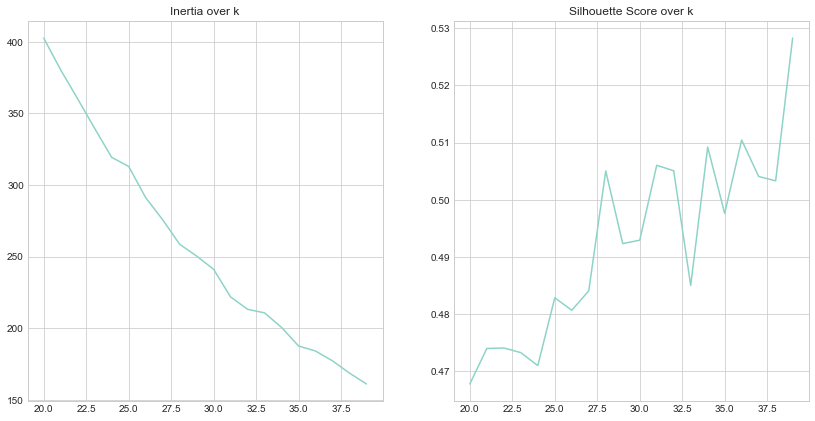

In [63]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
axes[0].plot(score_df.k, score_df.inertia)
axes[0].set_title('Inertia over k')
axes[1].plot(score_df.k, score_df.silhouette)
axes[1].set_title('Silhouette Score over k');
plt.savefig('../images/silhouette.png', dpi = 150, bbox_inches='tight', facecolor='w')

The Silhouette Coefficient is calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample. The Silhouette Coefficient for a sample is (b - a) / max(a, b). A higher silhouette score is thus better. As there appears to be a peak in silhouette score at 28, we will choose 28 clusters. 

In [64]:
cl = KMeans(n_clusters=28, random_state=42)
cl.fit(res_loc_ss)
res_loc['cluster'] = cl.labels_

In [65]:
centroids = pd.DataFrame(
    ss.inverse_transform(cl.cluster_centers_),
    columns=["latitude", "longitude"]
)

In [66]:
fig = px.scatter_mapbox(res_loc, lat="lat", lon="lng",
                        color="cluster", zoom=10, height=500, width=800)
fig.update_layout(
    mapbox_style="white-bg",
    mapbox_layers=[
        {
            "below": 'traces',
            "sourcetype": "raster",
            "source": [
                "https://maps-all.onemap.sg/v3/Default/{z}/{x}/{y}.png"
            ]
        }
      ])

fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

fig.show()

Clusters are visually coherent and correspond roughly to the size of a new town. 

In [67]:
res['cluster'] = res_loc['cluster']

In [68]:
res.to_csv('../data/restaurants_final.csv', index=False)

## Building Recommender System

In [69]:
res = pd.read_csv('../data/restaurants_final.csv')

In [70]:
rec = res.dropna(subset=['cleantext']).reset_index(drop=True)

In [71]:
rec['bagofwords'] = rec['category'].map(lambda x: x.lower()) + ' ' + rec['cleantext']

We use TFIDFVectorizer to transform the bagofwords document for each restaurant. This method gives higher weight to words that uniquely identify a document. 

In [72]:
tvec = TfidfVectorizer()
tvec_matrix = tvec.fit_transform(rec['bagofwords'])

In [73]:
tvec_matrix.shape

(5186, 48521)

### Computing Cosine Similarity
Cosine similarity measures the similarity between two vectors by calculating the cosine of the angle between them. It is the dot product of two vectors divided by the product of the magnitude of each vector. As the dot product is divided by the magnitude, data is normalised and only the angle difference is measured. The cosine of a 0 degree angle is 1, therefore the closer to 1 the cosine similarity is, the more similar the unique words for the restaurant are.

In [74]:
cosine_sim = linear_kernel(tvec_matrix)
pd.DataFrame(cosine_sim).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,...,5136,5137,5138,5139,5140,5141,5142,5143,5144,5145,5146,5147,5148,5149,5150,5151,5152,5153,5154,5155,5156,5157,5158,5159,5160,5161,5162,5163,5164,5165,5166,5167,5168,5169,5170,5171,5172,5173,5174,5175,5176,5177,5178,5179,5180,5181,5182,5183,5184,5185
0,1.000000,0.119129,0.078945,0.219086,0.073764,0.036047,0.164918,0.156358,0.109662,0.243277,0.223460,0.086742,0.247126,0.097748,0.124228,0.096761,0.144902,0.165909,0.147429,0.317114,0.197489,0.208702,0.151003,0.002846,0.313160,0.032884,0.097856,0.300374,0.237268,0.043916,0.137634,0.094236,0.222930,0.291135,0.252277,0.262369,0.218934,0.028227,0.044155,0.205741,0.229034,0.125615,0.360795,0.273697,0.017309,0.268248,0.213478,0.281639,0.107180,0.155492,...,0.260161,0.180381,0.193461,0.038935,0.053672,0.151976,0.240724,0.185777,0.034592,0.374819,0.128413,0.144569,0.247284,0.201849,0.232698,0.209783,0.208886,0.113306,0.120913,0.270712,0.032020,0.163671,0.103930,0.078112,0.074295,0.221736,0.135909,0.242731,0.189885,0.251333,0.059705,0.233761,0.231318,0.069724,0.064015,0.034395,0.290700,0.244239,0.180626,0.107566,0.165398,0.219792,0.073568,0.123688,0.223270,0.295828,0.192147,0.260856,0.169320,0.109255
1,0.119129,1.000000,0.116787,0.124309,0.058164,0.038872,0.129993,0.099331,0.088098,0.104868,0.115109,0.036554,0.088440,0.084757,0.081387,0.027185,0.280101,0.036252,0.068007,0.137635,0.163106,0.124474,0.222274,0.010986,0.095757,0.025943,0.069553,0.161522,0.093374,0.037687,0.070813,0.063208,0.148180,0.112811,0.124567,0.088905,0.253539,0.061726,0.017572,0.119356,0.094399,0.108280,0.134872,0.105825,0.066810,0.159154,0.078662,0.120573,0.054019,0.074717,...,0.144700,0.063662,0.109128,0.053828,0.045528,0.205980,0.121043,0.137354,0.012706,0.110997,0.068531,0.082980,0.130713,0.118210,0.087677,0.267037,0.116654,0.066449,0.056138,0.113333,0.000000,0.073048,0.066189,0.042846,0.054674,0.111748,0.119385,0.145435,0.125713,0.232675,0.024860,0.140476,0.269546,0.174496,0.013063,0.005356,0.134681,0.305017,0.099931,0.104130,0.079344,0.128815,0.073208,0.059186,0.118470,0.137457,0.106987,0.171165,0.100764,0.142517
2,0.078945,0.116787,1.000000,0.094192,0.027699,0.017128,0.132280,0.082240,0.072067,0.092559,0.084949,0.018908,0.070316,0.079334,0.026459,0.011030,0.152641,0.036481,0.056658,0.146007,0.160131,0.127585,0.164703,0.004715,0.095712,0.047704,0.072743,0.147140,0.087461,0.035002,0.025282,0.069943,0.126228,0.091503,0.097569,0.082181,0.192216,0.039176,0.010644,0.102689,0.075404,0.024175,0.124177,0.078094,0.028677,0.115268,0.063783,0.098674,0.044658,0.065466,...,0.128069,0.050668,0.113624,0.022383,0.016942,0.117100,0.125002,0.112197,0.018553,0.082622,0.037472,0.063396,0.124426,0.118198,0.072868,0.189208,0.109860,0.045809,0.042025,0.085899,0.019155,0.066494,0.065421,0.048813,0.028164,0.084784,0.063832,0.135233,0.114798,0.187635,0.009257,0.141132,0.211399,0.011380,0.018215,0.002299,0.144818,0.167453,0.068980,0.068821,0.093620,0.093510,0.105519,0.069118,0.088400,0.121463,0.117225,0.138179,0.113836,0.105998
3,0.219086,0.124309,0.094192,1.000000,0.055509,0.018454,0.161406,0.122478,0.090995,0.175266,0.202699,0.048534,0.153428,0.082929,0.090907,0.059255,0.127757,0.079959,0.112842,0.292331,0.207950,0.175047,0.148233,0.003691,0.216115,0.033908,0.077920,0.225384,0.165012,0.046441,0.086167,0.070915,0.203002,0.190491,0.175565,0.166639,0.199486,0.027072,0.016691,0.164094,0.134966,0.102922,0.226058,0.206256,0.022447,0.228237,0.144323,0.194370,0.079633,0.130082,...,0.210545,0.123757,0.168159,0.046520,0.038392,0.146891,0.194565,0.151111,0.042046,0.156197,0.077546,0.106626,0.209837,0.191329,0.149016,0.193394,0.154908,0.093583,0.077072,0.167184,0.043061,0.106739,0.076425,0.069357,0.061323,0.168972,0.113068,0.215621,0.169885,0.208654,0.036813,0.218480,0.192542,0.024162,0.037168,0.006331,0.219330,0.207325,0.155944,0.083256,0.133113,0.177616,0.114045,0.147208,0.181622,0.334120,0.171546,0.186344

### Defining Search Function to get PlaceID based on Restaurant Name

In [75]:
def findplaceid(name):
    """
    Inputs: Search String
    Outputs: Dataframe of restaurants which contain that search string
    """
    return rec[rec['title'].str.contains(name, case=False)][['title', 'placeid', 'address']]

In [76]:
findplaceid('tian tian')

,title,placeid,address
1412,Tian Tian Lai Nasi Lemak,ChIJAbN5HkET2jEREMPxEhXg3kY,"4 Woodlands Street 12, Marsiling Mall, Singapo..."
2810,Tian Tian Fisherman's Pier Seafood Restaurant,ChIJodByDQoZ2jERvBYW3yz9fiI,"42-44 Boat Quay, Singapore 049831"
3556,Tian Tian Hainanese Chicken Rice - Bedok Branch,ChIJ3wtJOjA92jERSluyf0BHvp8,"12 Jln Pari Burong, Singapore 488678"
4221,Tian Tian Sea Food Restaurant,ChIJqYiCNHcZ2jER5tWmlkm26b8,"239 Outram Rd, Singapore 169042"
4538,Tian Tian Lai Cooked Food,ChIJ2VFerfwW2jEROhxJcf6n67I,"453A Ang Mo Kio Ave 10, Singapore 561453"
4997,Tian Tian Lai Famous Teochew Fish Head Steamboat,ChIJ_5IuoTo92jERLe1rIqU3nLE,"3018 Bedok North Street 5, #06-10 EastLink, Si..."


### Defining Baseline Recommender

In [113]:
def baseline_recommend(placeids):
    """
    Inputs: Placeid
    Outputs: Dataframe of 10 randomly selected restaurants
    """
    return rec.sample(10, random_state=1)

### Defining Content-Based Recommender System

In [114]:
def recommend(placeids, cluster='NA', cosine_sim = cosine_sim):
    """
    Inputs: List of placeids, cluster number, and cosine similarity matrix
    Outputs: Dataframe of restaurants similar to the input restaurant
    """
    # Getting index of placeids
    placeids = [rec[rec['placeid'] == i].index[0] for i in placeids]
    # Extracting cosine similarity series for each placeid and averaging them
    cosine_sim_series = pd.Series(np.empty(cosine_sim[0].shape))
    for i in placeids: 
        cosine_sim_series += pd.Series(cosine_sim[i])
    cosine_sim_series = cosine_sim_series/len(placeids)
    # 
    cos_series = pd.Series(cosine_sim_series).sort_values(ascending=False)

    top_50_indexes = list(cos_series.iloc[len(placeids):51].index)
    
    df = rec.iloc[top_50_indexes, :].sort_values(['score', 'reviewsno'], ascending=False)

    if type(cluster)==int:
        df = df[df['cluster']==cluster]

    return df.head(10)

In [115]:
recommend(['ChIJ3wtJOjA92jERSluyf0BHvp8'])

,title,category,address,locatedin,street,city,postalcode,countrycode,website,url,phone,permclosed,ad,score,placeid,lat,lng,reviewsno,onestar,twostar,threestar,fourstar,fivestar,revtext,topic,keywords,cleantext,cluster,bagofwords
4644,Rocovo Restaurant,Restaurant,"151 Thomson Rd, Singapore 307606",Goldhill Plaza Mall,151 Thomson Rd,Singapore,307606,SG,hungrygowhere.com,https://www.google.com/maps/place/Rocovo+Resta...,+65 6256 3888,False,False,4.8,ChIJbcbT7ecZ2jER6-5PQNRf2wQ,1.318032,103.843943,18.0,0.0,0.0,1.0,1.0,16.0,Love love love the chicken rice here! Personal...,Restaurant,soup good noodle rice taste meat pork nice chi...,love love chicken rice good chicken rice singa...,26,restaurant love love chicken rice good chicken...
898,Sedap Corner Nasi Ayam Hainan,Chicken restaurant,"#01-40 Bukit Batok Central, Block 640, Singapo...",BUKIT BATOK CENTRE,"#01-40 Bukit Batok Central, Block 640",Singapore,650640,SG,jewkit.com.sg,https://www.google.com/maps/place/Sedap+Corner...,+65 6560 7102,False,False,4.8,ChIJAeRHdLMR2jERr_EeqZdb58s,1.349350,103.751563,5.0,0.0,0.0,0.0,1.0,4.0,My go to place to get chicken rice near my hou...,Local Restaurant,food good stall rice chicken price nice variet...,go place chicken rice house distance bukit_bat...,21,chicken restaurant go place chicken rice house...
303,Hoe Kee Kitchen 和記雞飯小厨,Hawker stall,"505 Jurong West Street 51, #01-39, Singapore 6...",Hong Kah Point,"505 Jurong West Street 51, #01-39",Singapore,640504,SG,NaN,https://www.google.com/maps/place/Hoe+Kee+Kitc...,NaN,False,False,4.6,ChIJIXISqyYP2jERcwslJAS9x48,1.349972,103.718647,5.0,0.0,0.0,0.0,2.0,3.0,All time favourite. Best chicken rice in the w...,Restaurant,soup good noodle rice taste meat pork nice chi...,time favourite good chicken rice west year tir...,6,hawker stall time favourite good chicken rice ...
278,A & I Hainanese Boneless Chicken Rice,Singaporean restaurant,"907 Jurong West Street 91, Singapore 640907",Block 907 HDB Jurong West,907 Jurong West Street 91,Singapore,640907,SG,NaN,https://www.google.com/maps/place/A+%26+I+Hain...,+65 9271 3319,False,False,4.5,ChIJUx08KpwP2jER_cJWhf24UOA,1.341238,103.685774,147.0,1.0,2.0,10.0,37.0,97.0,Come early to buy their chicken rice as they u...,Restaurant,soup good noodle rice taste meat pork nice chi...,chicken rice lunch time queue cheap delicious ...,6,singaporean restaurant chicken rice lunch time...
4809,OK Chicken Rice,Restaurant,"721 Ang Mo Kio Ave 8, 8, Singapore 560721",NaN,"721 Ang Mo Kio Ave 8, 8",Singapore,560721,SG,okchickenrice.oddle.me,https://www.google.com/maps/place/OK+Chicken+R...,+65 9026 7051,False,False,4.5,ChIJ62hHbP4b2jERaWaX5xRQQ6Y,1.372576,103.847954,84.0,4.0,4.0,1.0,13.0,62.0,We ordered 100 packets from OK Chicken Rice fo...,Restaurant,soup good noodle rice taste meat pork nice chi...,packet ok chicken rice food distribution activ...,22,restaurant packet ok chicken rice food distrib...
3725,Chuen Chuen Chicken Rice,Chicken restaurant,"2 Lor Sarina, Singapore 416647",NaN,2 Lor Sarina,Singapore,416647,SG,NaN,https://www.google.com/maps/place/Chuen+Chuen+...,+65 6742 3832,False,False,4.5,ChIJDbW92wUY2jERiKxGrgin4oA,1.318299,103.908118,49.0,0.0,3.0,3.0,11.0,32.0,Having SET A when cross by.\n$7.10\n-Yummy whi...,Restaurant,soup good noodle rice taste meat pork nice chi...,cross yummy white chicken crunchy bean_sprout ...,1,chicken restaurant cross yummy white chicken c...
1840,Yes! Nasi Kukus,Restaurant,"573 Woodlands Drive 16, #01-01, Singapore 730573",NaN,"573 Woodlands Drive 16, #01-01",Singapore,730573,SG,m.facebook.com,https://www.google.com/maps/place/Yes!+Nasi+Ku...,+65 9101 5711,False,False,4.4,ChIJARS2RyoT2jERIS0GNC7NnmY,1.431027,103.798726,340.0,10.0,7.0,27.0,95.0,201.0,A surprisingly great little store located in t...,Restaurant,soup good noodle rice taste meat pork nice chi...,great little store neighbourhood woodland chic...,0,restaurant great little store neighbourhood wo...
925,Shi Mei Hainanese Chicken Rice,Chicken restaurant,"371 Bukit Batok Stree

## Evaluating Recommender System

In order to evaluate relevance of the recommendations, we use Precision@K. I did consider using MAP@K but found this to be not as relevant, as we are not so concerned with ranking by similarity within the top 10 rank spots. In this case, K is 10. Precision is measured by TP/(TP+FP), where TP refers to the number of restaurants within the 10 recommended which share similar dishes with the input restaurant, while FP is 10-TP. I will take 5 random queries, visually inspect the restaurants to score the restaurant, and average out the scores for each system. 

In [84]:
rec.sample(5, random_state=42)[['title', 'category', 'placeid']]

,title,category,placeid
3949,L’éclair Pâtisserie (Jewel),Dessert shop,ChIJi4FZgx492jERofzb26AVA3U
1090,Ocean Seafood,Seafood Restaurant,ChIJT4e6P2IQ2jERAiMHSpq5L74
410,Devil's Hideout,Bar & grill,ChIJQeoW9OgF2jERFT5HpLYYr8Q
4283,Wan He Lou Kitchen,Seafood Restaurant,ChIJG10OjQcR2jER536nVbTvu98
3897,King Of Prawn Noodles,Restaurant,ChIJSwGT-eQ92jER5SWB1ayOO04


#### L’éclair Pâtisserie (Jewel)	
Baseline: 1/10

Recommender: 6/10 

In [95]:
baseline_recommend('ChIJi4FZgx492jERofzb26AVA3U')[['title', 'category']]

,title,category
3443,Uncle Penyet,Indonesian restaurant
1246,Taj Indian Food,Hawker stall
1650,Pasta Cucina,Hawker stall
1865,Camden Hill Restaurant & Bar,Bistro
1882,La Braceria,Italian restaurant
4885,Hansik Restaurant,Korean restaurant
3909,Tomi Sushi,Sushi restaurant
941,Yao Ba Cha Seafood Steamboat,Seafood Restaurant
2243,The Tree Cafe (E!Hub),Cafe
2234,Red House Seafood at Prinsep,Seafood restaurant


In [96]:
recommend(['ChIJi4FZgx492jERofzb26AVA3U'])[['title', 'category']]

,title,category
4972,Good Bites,Cafe
4279,Lemuel Chocolate (Westway),Chocolate cafe
4895,The Bread Shop,Cafe
5032,Munchi Delights,Hawker stall
4631,The Spot - Singapore,Fine Dining Restaurant
3194,5 by Sans Façon,French restaurant
243,The English House by Marco Pierre White,Traditional restaurant
4621,SweetSpot,Cafe
1818,Tamago-EN (Northpoint City),Cafe
106,15 Stamford by Alvin Leung,Fine Dining Restaurant


#### Ocean Seafood
Baseline: 2/10

Recommender: 8/10 

In [97]:
baseline_recommend('ChIJT4e6P2IQ2jERAiMHSpq5L74')[['title', 'category']]

,title,category
3443,Uncle Penyet,Indonesian restaurant
1246,Taj Indian Food,Hawker stall
1650,Pasta Cucina,Hawker stall
1865,Camden Hill Restaurant & Bar,Bistro
1882,La Braceria,Italian restaurant
4885,Hansik Restaurant,Korean restaurant
3909,Tomi Sushi,Sushi restaurant
941,Yao Ba Cha Seafood Steamboat,Seafood Restaurant
2243,The Tree Cafe (E!Hub),Cafe
2234,Red House Seafood at Prinsep,Seafood restaurant


In [98]:
recommend(['ChIJT4e6P2IQ2jERAiMHSpq5L74'])[['title', 'category']]

,title,category
3838,FPC Seafood,Chinese restaurant
2794,Leaf Corner Sembawang (Vegetarian) 慈素餐馆,Vegetarian restaurant
3405,Fatty Fong Seafood Restaurant,Coffee shop
4492,7 Wonders Seafood,Seafood restaurant
499,Chongqing Premium Grilled Fish,Chinese restaurant
2464,Keng Eng Kee Seafood,Seafood restaurant
1596,豐大厨私房菜 Chef Foong,Fish and seafood restaurant
5052,Paradise Classic at Marina Bay Link Mall,Chinese restaurant
2437,Seafood Park Pte. Ltd. Restaurant(Commonwealth),Chinese restaurant
478,West Co'z Cafe,Halal restaurant


#### Devil's Hideout
Baseline: 1/10

Recommender: 8/10 

In [99]:
baseline_recommend('ChIJQeoW9OgF2jERFT5HpLYYr8Q')[['title', 'category']]

,title,category
3443,Uncle Penyet,Indonesian restaurant
1246,Taj Indian Food,Hawker stall
1650,Pasta Cucina,Hawker stall
1865,Camden Hill Restaurant & Bar,Bistro
1882,La Braceria,Italian restaurant
4885,Hansik Restaurant,Korean restaurant
3909,Tomi Sushi,Sushi restaurant
941,Yao Ba Cha Seafood Steamboat,Seafood Restaurant
2243,The Tree Cafe (E!Hub),Cafe
2234,Red House Seafood at Prinsep,Seafood restaurant


In [100]:
recommend(['ChIJQeoW9OgF2jERFT5HpLYYr8Q'])[['title', 'category']]

,title,category
3779,Mazzo Singapore,Bistro
1841,13 Miles,Halal restaurant
574,Faber Valley Pub & Restaurant,Bistro
3531,Craze Kitchen,Cafe
248,Lazy Lizard NEWest,European Restaurant
4689,Viio Gastropub Restaurant & Bar,Fine Dining Restaurant
2874,J Bistro @ 45 Syed Alwi,Bistro
2932,Georges @ Tai Seng,Bistro
3357,Birdie Num Num Gastrobar,Gastropub
1184,The Pit,Bistro


#### Wan He Lou Kitchen	

Baseline: 2/10

Recommender: 7/10

In [101]:
baseline_recommend('ChIJG10OjQcR2jER536nVbTvu98')[['title', 'category']]

,title,category
3443,Uncle Penyet,Indonesian restaurant
1246,Taj Indian Food,Hawker stall
1650,Pasta Cucina,Hawker stall
1865,Camden Hill Restaurant & Bar,Bistro
1882,La Braceria,Italian restaurant
4885,Hansik Restaurant,Korean restaurant
3909,Tomi Sushi,Sushi restaurant
941,Yao Ba Cha Seafood Steamboat,Seafood Restaurant
2243,The Tree Cafe (E!Hub),Cafe
2234,Red House Seafood at Prinsep,Seafood restaurant


In [102]:
recommend(['ChIJG10OjQcR2jER536nVbTvu98'])[['title', 'category']]

,title,category
4157,Alma by Juan Amador,Fine dining restaurant
4156,Summer Pavilion,Chinese restaurant
4631,The Spot - Singapore,Fine Dining Restaurant
4199,Summer Palace,Chinese restaurant
4320,Mian Jia Noodle Bar,Chinese noodle restaurant
247,Chin Huat Live Seafood,Seafood restaurant
730,Naked Finn,Seafood restaurant
103,Jade,Chinese restaurant
1954,Mitzo Restaurant & Bar,Fine Dining Restaurant
5122,Hai Tien Lo,Chinese restaurant


#### King Of Prawn Noodles	

Baseline: 1/10

Recommender: 4/10

In [103]:
baseline_recommend('ChIJSwGT-eQ92jER5SWB1ayOO04')[['title', 'category']]

,title,category
3443,Uncle Penyet,Indonesian restaurant
1246,Taj Indian Food,Hawker stall
1650,Pasta Cucina,Hawker stall
1865,Camden Hill Restaurant & Bar,Bistro
1882,La Braceria,Italian restaurant
4885,Hansik Restaurant,Korean restaurant
3909,Tomi Sushi,Sushi restaurant
941,Yao Ba Cha Seafood Steamboat,Seafood Restaurant
2243,The Tree Cafe (E!Hub),Cafe
2234,Red House Seafood at Prinsep,Seafood restaurant


In [104]:
recommend(['ChIJSwGT-eQ92jER5SWB1ayOO04'])[['title', 'category']]

,title,category
3665,Jinjja Chicken,Restaurant
3161,Yi Zun Noodle,Chinese noodle restaurant
4597,Yummy Yap Eating House,Noodle shop
4320,Mian Jia Noodle Bar,Chinese noodle restaurant
4483,LeNu @ Northpoint City,Chinese noodle restaurant
2325,Big Prawn Noodle 大虾面,Hawker stall
2555,Prawn Noodle Bar,Restaurant
237,Tongue Tip Lanzhou Beef Noodles,Chinese noodle restaurant
3397,LeNu Chef Wai's Noodle Bar,Chinese noodle restaurant
5057,Feng Food,Taiwanese restaurant


P@K for baseline: 0.14

P@K for recommender system: 0.66

Nevertheless, this is just one metric on one dimension (dish similarity). There are other dimensions which may be important (e.g. price similarity, diversity) and it also does not measure how much the user actually likes the recommendation. To measure that, we would have to get user engagement data e.g. through surveys or click-through rate.

## Generating Flask Assets

In [105]:
rec.keys()

Index(['title', 'category', 'address', 'locatedin', 'street', 'city',
       'postalcode', 'countrycode', 'website', 'url', 'phone', 'permclosed',
       'ad', 'score', 'placeid', 'lat', 'lng', 'reviewsno', 'onestar',
       'twostar', 'threestar', 'fourstar', 'fivestar', 'revtext', 'topic',
       'keywords', 'cleantext', 'cluster', 'bagofwords'],
      dtype='object')

In [106]:
rec_web = rec[['title', 'category', 'address', 'locatedin', 'url',
       'score', 'placeid', 'reviewsno', 'cluster']]

In [107]:
np.save('../flask/assets/cosine_sim.npy', cosine_sim)

In [108]:
rec_web.to_csv('../flask/assets/rec_web.csv', index=False)

App deployed at http://kw-restaurant-recommender-app.herokuapp.com/

### Future Improvements
* Evaluate the precision of other similarity functions such as Jaccard Similarity
* Refine NLP (e.g. by adding non-descriptive terms like 'food' to stopwords) to better topic model remaining restaurants which were not classified well in the first instance
* Consider randomizing order of recommendations to improve novelty to encourage repeated use.
* Implement JavaScript in the UI of the app to make it more intuitive